In [1]:
!pip install triceratops &> /dev/null

In [ ]:
import numpy as np
import pandas as pd
import time
from lightkurve import TessLightCurve
import matplotlib.pyplot as plt
%matplotlib inline

import triceratops.triceratops as tr

## without contrast curve

In [2]:
ID = 470381900
sectors = np.array([19])
target = tr.target(ID=ID, sectors=sectors)

Next, let's define the aperture used to extract the light curve, plot an image of the field, and display a table of nearby stars.

The aperture should be a 2D numpy array with the formal `[[col#, row#], [col#, row#], [col#, row#], ...]`, where where each `[col#, row#]` is the column and row number of the pixel.

An image of the field can be plotted with the `.plot_field(sector, ap_pixels)` method. This method takes as optional arguments `sector` (the image sector you would like to plot) and `ap_pixels` (the aperture we just defined).

We can display a table of the stars in the image with the `.stars` attribute. This table contains the separation and position angle of each star from the target star, so that each can be identified in the plot. Note that the scale of a TESS pixel is about 20 arcseconds.

In [3]:
import lightkurve as lk

res = lk.search_targetpixelfile(f"TIC {ID}")
tpf = res[0].download()

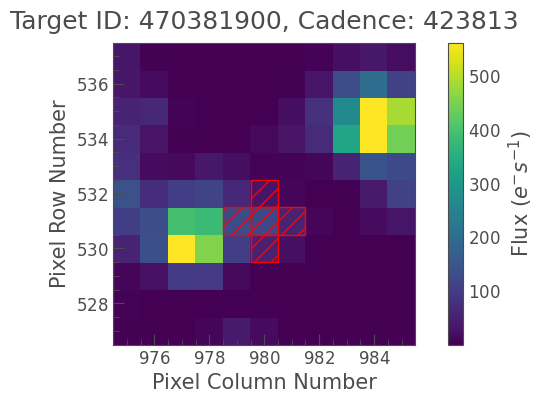

In [4]:
ax = tpf.plot(aperture_mask='pipeline')

In [5]:
pix_xy = np.nonzero(tpf.pipeline_mask)
# pixel locations of aperture
aper = np.c_[pix_xy[1] + tpf.column, pix_xy[0] + tpf.row]

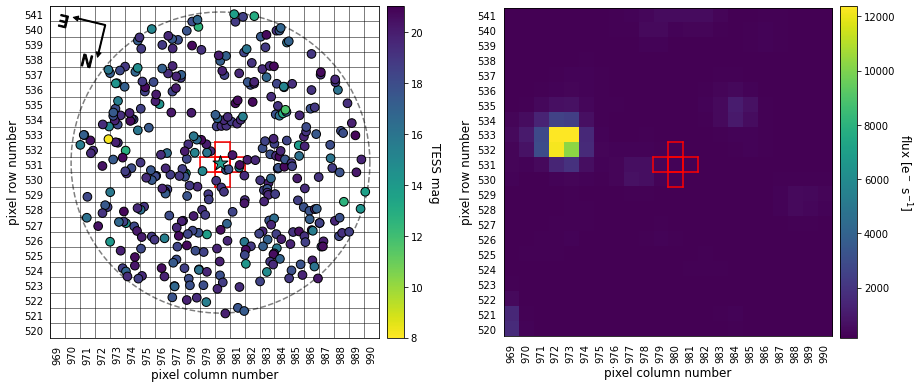

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N)
0,470381900,13.9664,12.233,11.604,11.331,65.280563,48.819914,0.254505,0.280475,3181.00,15.376100,0.000,0.000
1,470381907,17.6880,15.466,15.593,15.289,65.276569,48.822072,1.220000,1.993890,6264.00,-0.185700,12.248,309.367
2,667421445,17.9456,NaN,NaN,NaN,65.275253,48.821595,0.970000,1.503530,5520.00,0.032989,13.967,295.689
3,667421446,20.2039,NaN,NaN,NaN,65.274735,48.816086,NaN,NaN,NaN,NaN,19.515,225.077
4,667421451,19.4761,NaN,NaN,NaN,65.287447,48.816698,NaN,NaN,NaN,1.671100,20.007,125.351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,470377924,13.6461,11.202,9.956,9.485,65.196110,48.816915,NaN,24.426100,3985.84,0.087711,200.481,266.945
359,667421554,20.1448,NaN,NaN,NaN,65.212027,48.852752,NaN,NaN,NaN,NaN,200.872,306.078
360,667421561,19.8483,NaN,NaN,NaN,65.259613,48.874147,NaN,NaN,NaN,-0.637102,201.448,345.744
361,667421638,19.3956,NaN,NaN,NaN,65.318859,48.869891,0.770000,0.584011,4789.00,1.520190,201.500,26.746


In [6]:
target.plot_field(sector=sectors[0], ap_pixels=aper)
 
target.stars

Leave only the target because nearby stars have been ruled out as source of the signal based on follow-up photometry.

In [7]:
target.stars = target.stars[target.stars.ID==str(ID)]
target.stars

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N)
0,470381900,13.9664,12.233,11.604,11.331,65.280563,48.819914,0.254505,0.280475,3181.0,15.3761,0.0,0.0


In [8]:
#final
target.stars['mass'] = 0.255 #empirical
target.stars['rad'] = 0.2775
target.stars['Teff'] = 3186

/tmp/ipykernel_7115/3259046436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.stars['mass'] = 0.255 #empirical
/tmp/ipykernel_7115/3259046436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.stars['rad'] = 0.2775
/tmp/ipykernel_7115/3259046436.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [9]:
target.stars

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N)
0,470381900,13.9664,12.233,11.604,11.331,65.280563,48.819914,0.255,0.2775,3186,15.3761,0.0,0.0


https://exofop.ipac.caltech.edu/tess/target.php?id=470381900

In [10]:
tdepth = 11012.4838927907e-6 #± 1568.8007
P_orb = 2.50071474655903 #± .000511482

In [11]:
apertures = np.array([aper])
target.calc_depths(tdepth=tdepth, all_ap_pixels=apertures)

target.stars

/home/jp/github/research/transit/triceratops/triceratops/triceratops.py:520: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.stars["fluxratio"] = flux_ratios
/home/jp/github/research/transit/triceratops/triceratops/triceratops.py:527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.stars["tdepth"] = tdepths


,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N),fluxratio,tdepth
0,470381900,13.9664,12.233,11.604,11.331,65.280563,48.819914,0.255,0.2775,3186,15.3761,0.0,0.0,1.0,0.011012


After doing this, we can calculate the probability of each scenario using the `.calc_prob(time, flux_0, flux_err_0, P_orb)` method, which requires as arguments `time` (times from phase-folded light curve in units of days from transit center), `flux_0` (normalized flux from phase-folded light curve), `flux_err_0` (flux error values of the target's phase-folded light curve), and `P_orb` (orbital period of the TOI in days).

If you have a lot of data points, I recommend binning your light curve down to ~100 to save time. Binning your data is poor practice when fitting light curves for a planet's parameters, but it doesn't yield significantly different results for our purposes. This should only take a few minutes.

In [12]:
# read in the light curve
lc = pd.read_csv("../vespa/all_scenarios/tess_folded.csv", delim_whitespace=True, header=None)
time, flux, flux_err = lc[0].values, lc[1].values, lc[2].values

In [13]:
%%time
lc_binsize = (time.max()-time.min())/100
lc = TessLightCurve(time=time, flux=flux, flux_err=flux_err)#.bin(time_bin_size=lc_binsize)

target.calc_probs(time=lc.time.value, 
                  flux_0=lc.flux.value, 
                  flux_err_0=np.nanmean(lc.flux_err.value), 
                  P_orb=P_orb,
                  parallel=True
                 )

Calculating TP, EB, and EBx2P scenario probabilities for 470381900.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 470381900.
Calculating STP, SEB, and SEBx2P scenario probabilities for 470381900.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 470381900.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 470381900.
CPU times: user 2min 29s, sys: 6.58 s, total: 2min 35s
Wall time: 1min 2s


Now that that's done, let's check out a table of our results with the `.probs` attribute and calculate the false positive probability and nearby false positive probability using the `.FPP`  and `.NFPP` attributes. We expect a scatter of a few percent in our probabilities, so don't be alarmed if it's slightly different with each run. We can also plot the transit fits of each scenario using the `.plot_fits(time, flux_0, flux_err_0)` method.

In [14]:
df_results = target.probs
print("FPP =", np.round(target.FPP, 4))
print("NFPP =", np.round(target.NFPP, 4))
df_results

FPP = 0.0196
NFPP = 0.0


,ID,scenario,M_s,R_s,P_orb,inc,ecc,w,R_p,M_EB,R_EB,prob
0,470381900,TP,0.255000,0.277500,2.500715,89.858363,0.214682,79.881490,2.853137,0.000000,0.000000,0.837775
1,470381900,EB,0.255000,0.277500,2.500715,86.641320,0.496931,293.749265,0.000000,0.240331,0.266169,0.000057
2,470381900,EBx2P,0.255000,0.277500,5.001429,87.793081,0.333648,272.619234,0.000000,0.244967,0.270256,0.001076
3,470381900,PTP,0.255000,0.277500,2.500715,89.398729,0.286431,143.254027,2.980654,0.000000,0.000000,0.074987
4,470381900,PEB,0.255000,0.277500,2.500715,84.749209,0.708451,324.230695,0.000000,0.235019,0.261469,0.000003
5,470381900,PEBx2P,0.255000,0.277500,5.001429,87.549890,0.489619,313.126986,0.000000,0.247222,0.272239,0.000400
6,470381900,STP,0.242989,0.268514,2.500715,89.818956,0.235042,124.135745,4.031741,0.000000,0.000000,0.016008
7,470381900,SEB,0.105796,0.128174,2.500715,88.470880,0.455943,275.098408,0.000000,0.045704,0.100000,0.000082
8,470381900,SEBx2P,0.228123,0.255341,5.001429,87.862548,0.266236,278.413278,0.000000,0.219651,0.247766,0.000472
9,470381900,DTP,0.255000,0.277500,2.500715,87.840090,0.930249,216.483879,2.791792,0.000000,0.000000,0.067657


* EB: No unresolved companion. Eclipsing binary with Porb around target star | 0.0341
* EBx2P: | 0.0454
* PTP: Unresolved bound companion. Transiting planet with Porb around primary star | 0.891
* SEB: Unresolved bound companion. Eclipsing binary with Porb around secondary star | 0.00216 (HEB)
* DTP: Unresolved background star. Transiting planet with Porb around target star | no counterpart in vespa

In [15]:
np.round(np.mean(target.FPP), 4)

0.0196

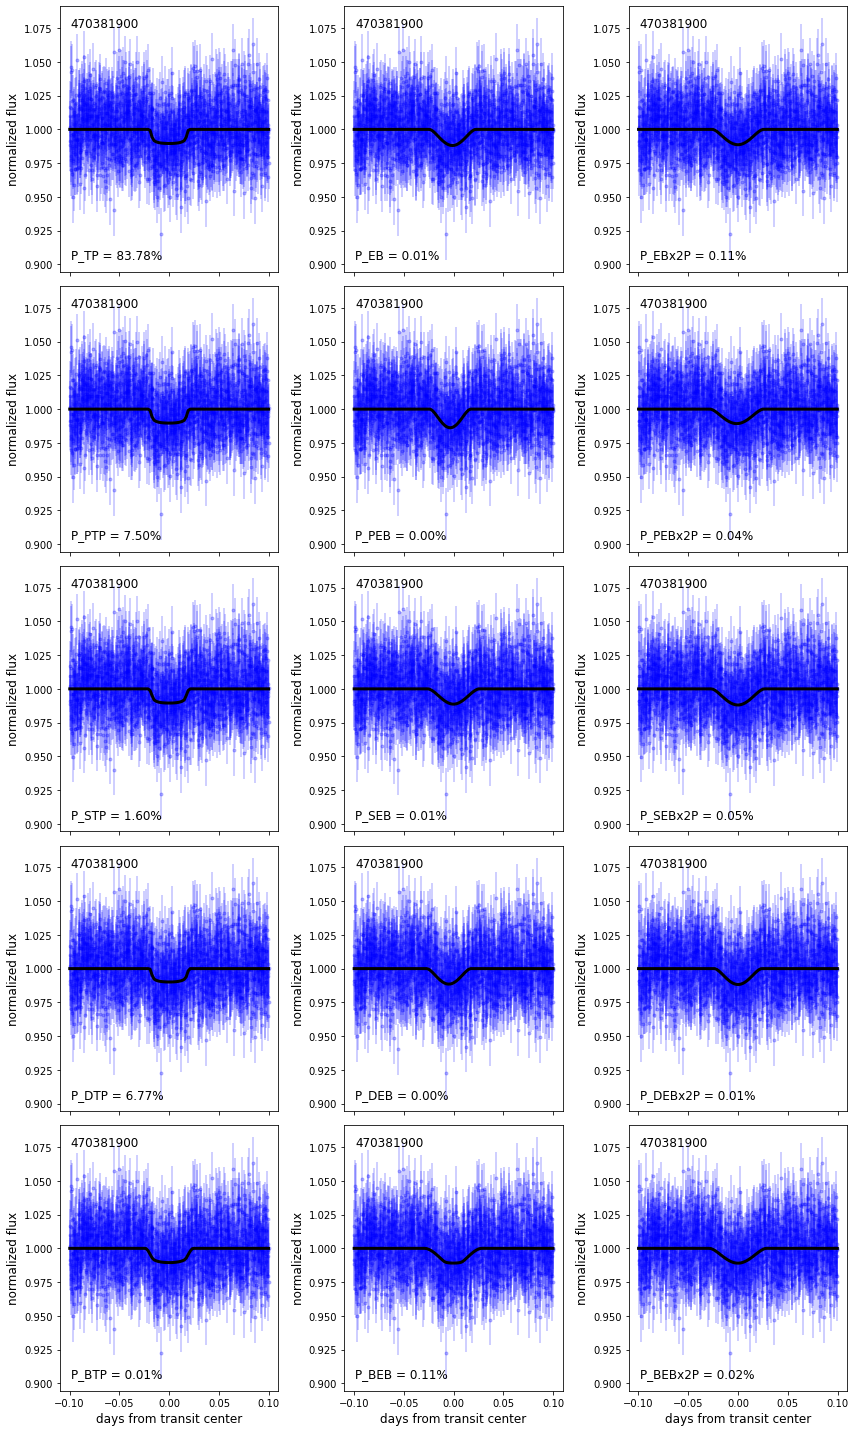

In [16]:
fig = target.plot_fits(time=time, flux_0=flux, flux_err_0=np.nanmean(flux_err))

# for i,row in df_results.iterrows():
#     ax = fig.axes[i]
#     p = row['prob']
#     ax.annotate(f"{p:.2f}",xy=(0.05,0.05),xycoords="xyes fraction", fontsize=12)

In [17]:
fig.savefig("../paper/figures/triceratops_without_cc.pdf")

If you plan to quote these results in a paper, you should run `.calc_probs()` several times and quote the mean and standard deviation of the FPP. This way, you can show that your result is not sensitive to the intrinsic scatter in the calculation.

We illustrate this below by calculating the FPP 20 times. We use the optional argument `parallel` to enable parallel light curve simulation, which makes the calculation ~5x faster. Enabling parallelization yields the same results as the non-parallel option, so you should feel free to set this argument to `True` at all times.

In [18]:
print(f"{target.probs.prob[0]:.4f}+{target.probs.prob[3]:.4f}+{target.probs.prob[9]:.4f}")

0.8378+0.0750+0.0677


In [19]:
1-(target.probs.prob[0]+target.probs.prob[3]+target.probs.prob[9])

0.019581423657968777

In [20]:
target.FPP

0.019581423657968777

## with contrast curve

Next, let's repeat this calculation while folding in follow up data. We'll see how including a contrast curve of the target star changes these results and further constrains the FPP. Note that the contrast curve file should be a csv with no headers, where the first column is the angular separation (in arcseconds) and the second column is the $\Delta$ mag.

In [22]:
outdir="../vespa/all_scenarios"
contrastcurve_file = outdir+"/Gemini_20201203_r.cc"
cc = pd.read_csv(contrastcurve_file, delim_whitespace=True, names=['r','dmag'])
cc['dmag'] = cc['dmag'].apply(lambda x: x*2)

In [23]:
cc.to_csv("../vespa/all_scenarios/Gemini_20201203_r_hypot.cc", sep=' ', header=False, index=False)

In [24]:
cc1 = pd.read_csv("../vespa/all_scenarios/Gemini_20201203_r.cc", names=['r','dmag'], delim_whitespace=True)
cc2 = pd.read_csv("../vespa/all_scenarios/Gemini_20201203_z.cc", names=['r','dmag'], delim_whitespace=True)
cc3 = pd.read_csv("../vespa/all_scenarios/Gemini_20211014_r.cc", names=['r','dmag'], delim_whitespace=True)
cc4 = pd.read_csv("../vespa/all_scenarios/Gemini_20211014_z.cc", names=['r','dmag'], delim_whitespace=True)
cc5 = pd.read_csv("../vespa/all_scenarios/Gemini_20201203_r_hypot.cc", names=['r','dmag'], delim_whitespace=True)

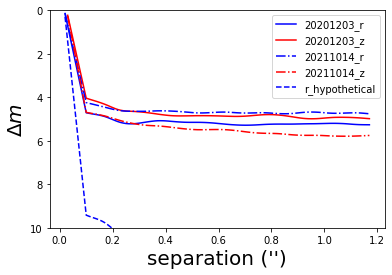

In [25]:
plt.plot(cc1.r, cc1.dmag, 'b-', label='20201203_r');
plt.plot(cc2.r, cc2.dmag, 'r-', label='20201203_z');
plt.plot(cc3.r, cc3.dmag, 'b-.', label='20211014_r');#'562nm');
plt.plot(cc4.r, cc4.dmag, 'r-.', label='20211014_z');#'832nm');
plt.plot(cc5.r, cc5.dmag, 'b--', label='r_hypothetical');
plt.ylim(10,0);
plt.ylabel("$\\Delta m$", fontsize=20);
plt.xlabel("separation ('')", fontsize=20);
plt.legend()

In [34]:
#save to csv the one with highest contrast
# contrastcurve_file = "../vespa/Gemini_20211014_z.cc"
contrastcurve_file = "../vespa/all_scenarios/Gemini_20201203_z.cc"
c = pd.read_csv(contrastcurve_file, delim_whitespace=True, names=['r','dmag'])
fp = contrastcurve_file.split('/')[-1][:-3]+'.csv'
c.to_csv(fp, header=None, index=False)
print(f"Saved: {fp}")

Saved: Gemini_20201203_z.csv


In [41]:
%%time
lc_binsize = (time.max()-time.min())/100
lc = TessLightCurve(time=time, flux=flux, flux_err=flux_err).bin(time_bin_size=lc_binsize)

target.calc_probs(time=lc.time.value, 
                  flux_0=lc.flux.value, 
                  flux_err_0=np.nanmean(lc.flux_err.value), 
                  contrast_curve_file=fp,
                  P_orb=P_orb,
                  parallel=True
                 )

Calculating TP, EB, and EBx2P scenario probabilities for 470381900.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 470381900.
Calculating STP, SEB, and SEBx2P scenario probabilities for 470381900.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 470381900.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 470381900.
CPU times: user 40.3 s, sys: 732 ms, total: 41 s
Wall time: 35.6 s


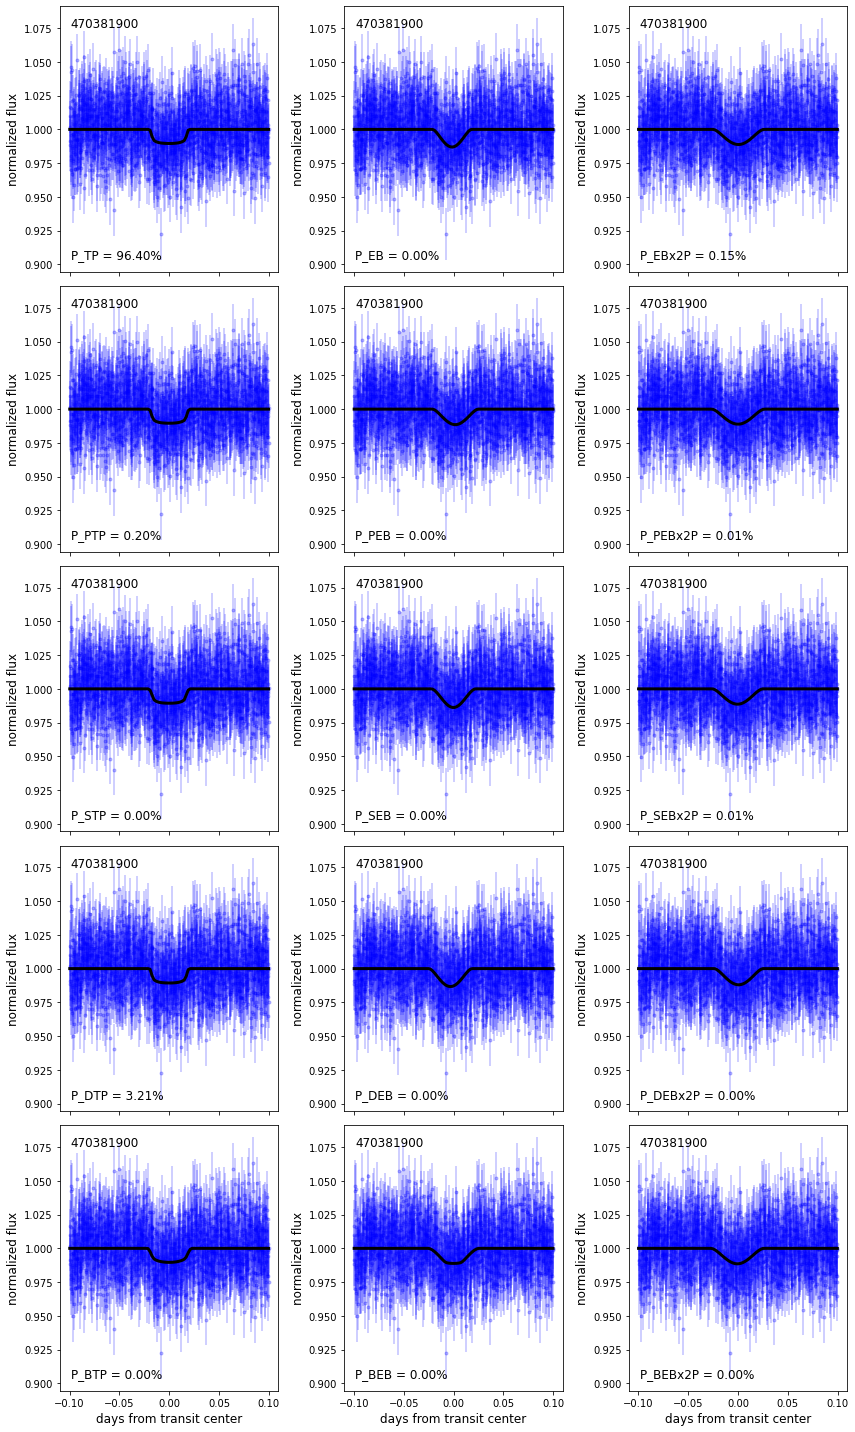

In [42]:
fig2 = target.plot_fits(time=time, flux_0=flux, flux_err_0=np.nanmean(flux_err))

In [43]:
print(f"{target.probs.prob[0]:.4f}+{target.probs.prob[3]:.4f}+{target.probs.prob[9]:.4f}")

0.9640+0.0020+0.0321


In [44]:
1-(target.probs.prob[0]+target.probs.prob[3]+target.probs.prob[9])

0.001950540809695922

In [45]:
target.FPP

0.001950540809695922

In [46]:
fig2.savefig("../paper/figures/triceratops_with_cc_562nm.pdf")

In [47]:
#save to csv the one with highest contrast
contrastcurve_file = "../vespa/all_scenarios/Gemini_20201203_r_hypot.cc"
c = pd.read_csv(contrastcurve_file, delim_whitespace=True, names=['r','dmag'])
fp = contrastcurve_file.split('/')[-1][:-3]+'.csv'
c.to_csv(fp, header=None, index=False)
print(f"Saved: {fp}")

Saved: Gemini_20201203_r_hypot.csv


In [48]:
%%time
lc_binsize = (time.max()-time.min())/100
lc = TessLightCurve(time=time, flux=flux, flux_err=flux_err).bin(time_bin_size=lc_binsize)

target.calc_probs(time=lc.time.value, 
                  flux_0=lc.flux.value, 
                  flux_err_0=np.nanmean(lc.flux_err.value), 
                  contrast_curve_file=fp,
                  P_orb=P_orb
                 )

Calculating TP, EB, and EBx2P scenario probabilities for 470381900.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 470381900.
Calculating STP, SEB, and SEBx2P scenario probabilities for 470381900.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 470381900.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 470381900.
CPU times: user 2min 33s, sys: 352 ms, total: 2min 33s
Wall time: 2min 43s


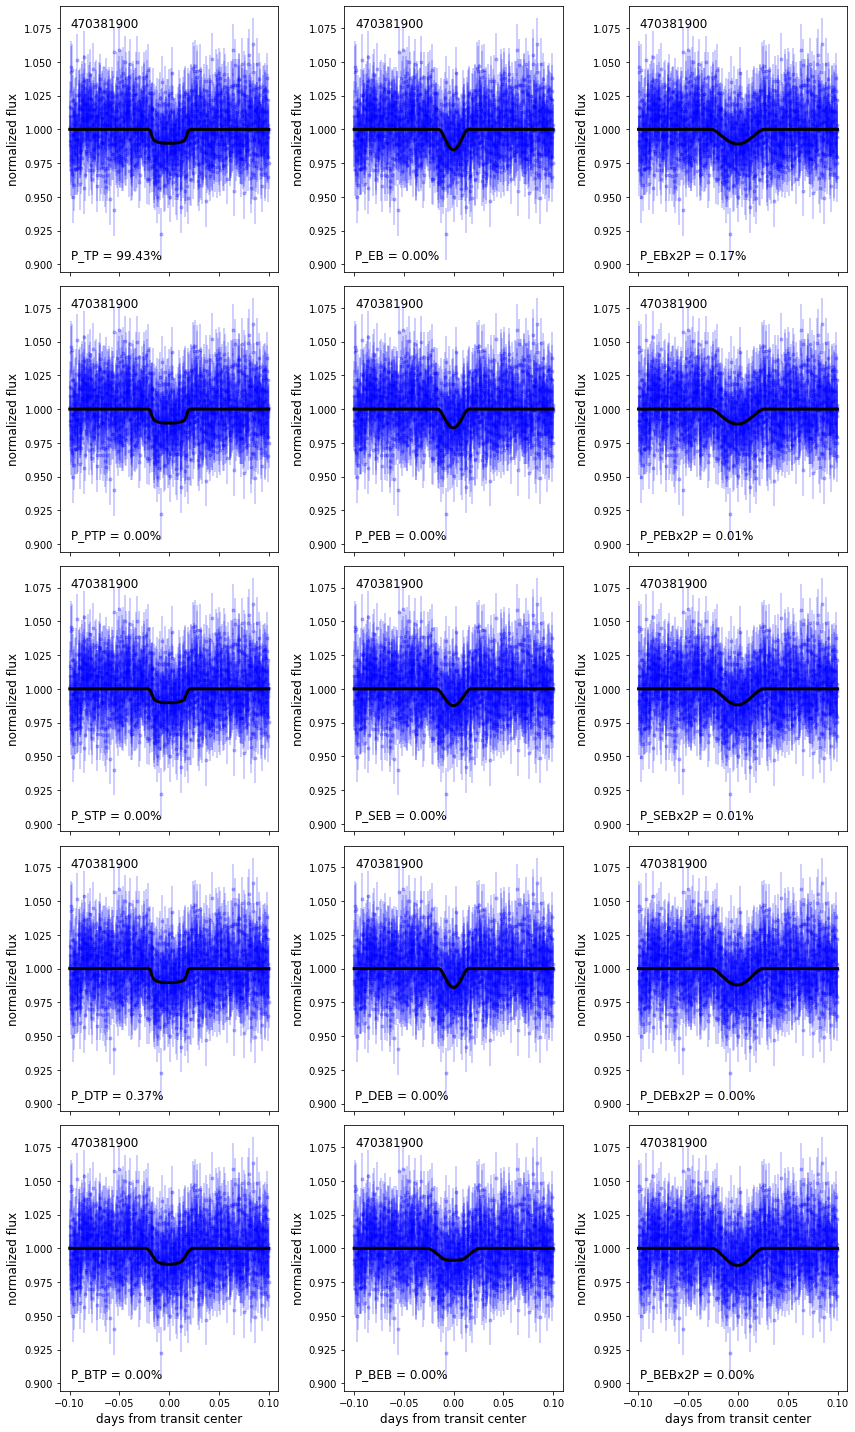

In [49]:
fig3 = target.plot_fits(time=time, flux_0=flux, flux_err_0=np.nanmean(flux_err))

In [50]:
fig3.savefig("../paper/figures/triceratops_with_cc_hypothetical.pdf")